In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import ee
import geemap
# 导入相关库
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,8)

In [4]:
# 去云、云阴影、雪掩膜函数
def maskL8sr(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    return image.updateMask(mask)
# landsat影像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}
landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate('2020-01-01', '2020-12-31').map(maskL8sr)
Map.addLayer(landsat_images.median().clip(roi),visParams,'landsat image')

# 绘制散点图

In [ ]:
region = 'wuhan'
sample_region = 'WUHAN'
year = 2020

In [ ]:
pw_nw = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_noseason' + str(year))
permanent_water = pw_nw.filter(ee.Filter.eq('waterclass',1)).randomColumn('random',1,'uniform').sort('random').limit(500)
no_water = pw_nw.filter(ee.Filter.eq('waterclass',0)).randomColumn('random',1,'uniform').sort('random').limit(3000)
print('抽样的永久性水体： ',permanent_water.size().getInfo())
print('抽样的非水体： ',no_water.size().getInfo())
## 季节性样本，抽样
# sw = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_season' + str(year)+'_v2').randomColumn('random',1,'uniform').sort('random').limit(500)
sw = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_season' + str(year)).randomColumn('random',1,'uniform').sort('random').limit(500)
print('抽样的季节性水体： ',sw.size().getInfo())
## 季节性样本，分类
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
cluster_samples = ee.FeatureCollection([permanent_water,no_water]).flatten()
clusterer = ee.Clusterer.wekaKMeans(2).train(cluster_samples,bands)
q = ee.FeatureCollection(sw.cluster(clusterer))
q1 = q.filter(ee.Filter.eq('cluster',1))
q0 = q.filter(ee.Filter.eq('cluster',0))
b1 = ee.FeatureCollection(q1).filter(ee.Filter.lt('AWEI',0)).size()
b2 = ee.FeatureCollection(q1).filter(ee.Filter.gt('AWEI',0)).size()
c1 = ee.FeatureCollection(q0).filter(ee.Filter.lt('AWEI',0)).size()
c2 = ee.FeatureCollection(q0).filter(ee.Filter.gt('AWEI',0)).size()
qq1 = ee.Algorithms.If(ee.Number(b1).lt(ee.Number(b2)),q1.map(lambda i:i.set({'waterclass':1})),q1.map(lambda i:i.set({'waterclass':0})))
qq0 = ee.Algorithms.If(ee.Number(c1).lt(ee.Number(c2)),q0.map(lambda i:i.set({'waterclass':1})),q0.map(lambda i:i.set({'waterclass':0})))
seasonWater = ee.FeatureCollection([qq1,qq0]).flatten()
## 合并
total_Samples = ee.FeatureCollection([permanent_water,no_water,seasonWater]).flatten()
print("筛选前，剩余的样本数： ",total_Samples.size().getInfo())

## 二维散点图

In [ ]:
# 永久性水体、非水体的样本
filtered_sample1 = ee.FeatureCollection('users/311605001111/daqing_new_noseason2020')
print(filtered_sample1.size().getInfo())

# 季节性水体的样本
filtered_sample = ee.FeatureCollection('users/311605001111/daqing_new_season2020')
print(filtered_sample.size().getInfo())

In [ ]:
# x = 'B5'
# y = 'B4'
x = 'B3'
y = 'B6'
# 永久性水体、非水体的样本
land_x1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo())
land_y1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
water_x1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
# 季节性水体的样本
land_x = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo())
land_y = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
water_x = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 

plt.figure(figsize=(8, 6))

plt.scatter(water_x,water_y,s=5,c='blue', label = 'season_water')
plt.scatter(land_x,land_y,s=5,c='red', label = 'season_land')
# plt.scatter(water_x1,water_y1,s=2,c='#4ad6c3', label = 'permanent_water')
# plt.scatter(land_x1,land_y1,s=2,c='#bfd69b', label = 'land')

# # B5/B4
# plt.xlim(0,6300)
# plt.ylim(-100,2700)
# plt.title('B4/B5')

# B3/B6
plt.xlim(0,2400)
plt.ylim(-100,4000)
plt.tick_params(labelsize=18)

plt.xlabel(x,fontsize=25)    
plt.ylabel(y,fontsize=25)

plt.title('B3/B6',fontsize=27)
plt.legend(prop={'size':18},markerscale=6,loc = 'upper right')
# plt.legend(prop={'size':11},markerscale=3,loc = 'lower right')
plt.show()

## 三维散点图

In [ ]:
# print(no_water.filter(ee.Filter.eq('waterclass',1)).size().getInfo())
# 永久性水体、非水体的样本
permanent_water = total_Samples.filter(ee.Filter.eq('point_type','permanent_water'))
no_water = total_Samples.filter(ee.Filter.eq('point_type','no_water'))

filtered_sample1 = ee.FeatureCollection([permanent_water,no_water]).flatten()
print(filtered_sample1.size().getInfo())

# 季节性水体的样本
filtered_sample = total_Samples.filter(ee.Filter.eq('point_type','season'))
print(filtered_sample.size().getInfo())

### 静态

In [ ]:
%matplotlib inline

x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'
# 全部样本
land_x1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

land_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

# 创建一个三维的绘图工程
plt.figure(figsize=(8, 6))

ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(water_x1, water_y1, water_z1, s=2, c='blue', label = 'permanent_water')
ax.scatter(land_x1, land_y1, land_z1, s=2,c='red', label = 'land')
# ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'season_water')
# ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'season_land')  
ax.view_init(32,-51)
# 坐标轴
ax.set_xlim3d(-0.85,1.1)
ax.set_ylim3d(-0.8,1.1)
ax.set_zlim3d(-15000,5300)
ax.set_xlabel(x,fontsize = 11)
ax.set_ylabel(y,fontsize = 11)
ax.set_zlabel(z,labelpad = 11,rotation=90,fontsize = 11)
plt.xticks([-0.5,0,0.5,1.0])
plt.yticks([-0.5,0,0.5,1.0])
plt.title('Title: NDVI/MNDWI/AWEI') 
plt.legend(loc='upper right',markerscale=4,prop={'size':10})
plt.show()

### 动态

In [ ]:
%matplotlib notebook

x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'
# 全部样本
land_x1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

land_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

# 创建一个三维的绘图工程
plt.figure(figsize=(10,8))

ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(water_x1, water_y1, water_z1, s=2, c='blue', label = 'permanent_water')
ax.scatter(land_x1, land_y1, land_z1, s=2,c='red', label = 'land')
# ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'season_water')
# ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'season_land')  
ax.view_init(32,-51)
# 坐标轴
ax.set_xlim3d(-0.85,1.1)
ax.set_ylim3d(-0.8,1.1)
ax.set_zlim3d(-15000,5300)
ax.set_xlabel(x,fontsize = 11)
ax.set_ylabel(y,fontsize = 11)
ax.set_zlabel(z,labelpad = 11,rotation=90,fontsize = 11)
plt.xticks([-0.5,0,0.5,1.0])
plt.yticks([-0.5,0,0.5,1.0])
plt.title('Title: NDVI/MNDWI/AWEI') 
plt.legend(loc='upper right',markerscale=6,prop={'size':16})
plt.show()

# k-mean筛选

In [5]:
## 异常值去除
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
#### cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft
#### k-mean聚类
def k_mean(sampleSET):
    clusterer = ee.Clusterer.wekaKMeans(2).train(sampleSET,bands)
    result = sampleSET.cluster(clusterer)
    right = result.map(Compare).filter(ee.Filter.eq('eq',0))
    error = result.map(Compare).filter(ee.Filter.eq('eq',1))
    filtered_sample = ee.FeatureCollection(ee.Algorithms.If(right.size().gt(error.size()),right,error))
    return filtered_sample
def k_mean_outlier(sampleSET):
    clusterer = ee.Clusterer.wekaKMeans(2).train(sampleSET,bands)
    result = sampleSET.cluster(clusterer)
    right = result.map(Compare).filter(ee.Filter.eq('eq',0))
    error = result.map(Compare).filter(ee.Filter.eq('eq',1))
    filtered_sample = ee.FeatureCollection(ee.Algorithms.If(right.size().lt(error.size()),right,error))
    return filtered_sample

In [6]:
# region = 'daqing'
# sample_region = 'DAQING'
# region = 'tianjin'
# sample_region = 'TIANJIN'
# region = 'wuhan'
# sample_region = 'WUHAN'
region = 'prd'
sample_region = 'PRD'
# region = 'tibet'
# sample_region = 'TIBET'

name = 'Region D'
year = 2019

In [7]:
pw_nw_n = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_noseason' + str(year))
pw_nw = pw_nw_n.map(lambda i : i.set({'AWEI':ee.Number(i.get('AWEI')).divide(10000)}))
permanent_water = pw_nw.filter(ee.Filter.eq('waterclass',1)).randomColumn('random',1,'uniform').sort('random').limit(500)
no_water = pw_nw.filter(ee.Filter.eq('waterclass',0)).randomColumn('random',1,'uniform').sort('random').limit(3000)
print('抽样的永久性水体： ',permanent_water.size().getInfo())
print('抽样的非水体： ',no_water.size().getInfo())
## 季节性样本，抽样
# sww = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_season' + str(year)+'_v2')
sww = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_season' + str(year))
sw = sww.map(lambda i : i.set({'AWEI':ee.Number(i.get('AWEI')).divide(10000)})).randomColumn('random',1,'uniform').sort('random').limit(500)
print('抽样的季节性水体： ',sw.size().getInfo())
## 季节性样本，分类
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
cluster_samples = ee.FeatureCollection([permanent_water,no_water]).flatten()
clusterer = ee.Clusterer.wekaKMeans(2).train(cluster_samples,bands)
q = ee.FeatureCollection(sw.cluster(clusterer))
q1 = q.filter(ee.Filter.eq('cluster',1))
q0 = q.filter(ee.Filter.eq('cluster',0))
b1 = ee.FeatureCollection(q1).filter(ee.Filter.lt('AWEI',0)).size()
b2 = ee.FeatureCollection(q1).filter(ee.Filter.gt('AWEI',0)).size()
c1 = ee.FeatureCollection(q0).filter(ee.Filter.lt('AWEI',0)).size()
c2 = ee.FeatureCollection(q0).filter(ee.Filter.gt('AWEI',0)).size()
qq1 = ee.Algorithms.If(ee.Number(b1).lt(ee.Number(b2)),q1.map(lambda i:i.set({'waterclass':1})),q1.map(lambda i:i.set({'waterclass':0})))
qq0 = ee.Algorithms.If(ee.Number(c1).lt(ee.Number(c2)),q0.map(lambda i:i.set({'waterclass':1})),q0.map(lambda i:i.set({'waterclass':0})))
seasonWater = ee.FeatureCollection([qq1,qq0]).flatten()
## 合并
total_Samples = ee.FeatureCollection([permanent_water,no_water,seasonWater]).flatten()
print("筛选前，剩余的样本数： ",total_Samples.size().getInfo())

抽样的永久性水体：  500
抽样的非水体：  3000
抽样的季节性水体：  468
筛选前，剩余的样本数：  3968


In [ ]:
# print(total_Samples.filter(ee.Filter.eq('point_type','season')).filter(ee.Filter.lt('AWEI',-1)).aggregate_array('AWEI').getInfo())
# print(total_Samples.filter(ee.Filter.lt('AWEI',-1)).aggregate_array('AWEI').getInfo())

## 筛选前

In [8]:
# 永久水+ 陆地
no_water = no_water.filter(ee.Filter.lt('AWEI',1))
filtered_samples1 = ee.FeatureCollection([permanent_water,no_water]).flatten()
print(filtered_samples1.size().getInfo())
# 季节性水体的样本
filtered_samples = ee.FeatureCollection([seasonWater]).flatten().filter(ee.Filter.gt('AWEI',-1))
print(filtered_samples.size().getInfo())

3487
466


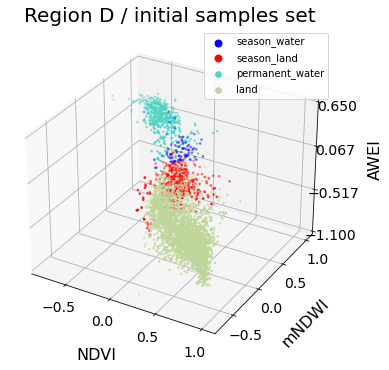

In [9]:
# %matplotlib notebook
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline
x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'

land_x =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 


land_x1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 
# 创建一个三维的绘图工程
# plt.figure(figsize=(10, 8))
plt.figure(figsize=(8, 6))

ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'season_water')
ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'season_land')  
ax.scatter(water_x1, water_y1, water_z1, s=2, c='#4ad6c3', label = 'permanent_water')
ax.scatter(land_x1, land_y1, land_z1, s=2,c='#bfd69b', label = 'land')

# ax.view_init(32,-51)
# 坐标轴
ax.set_xlim3d(-0.85,1.1)
ax.set_ylim3d(-0.8,1.1)
ax.set_zlim3d(-1.1,0.65)
plt.tick_params(labelsize=14)
ax.set_xlabel(x,labelpad = 16,fontsize = 16)
ax.set_ylabel(y,labelpad = 16,fontsize = 16)
ax.set_zlabel(z,labelpad = 16,rotation=90,fontsize = 16)
plt.xticks([-0.5,0,0.5,1.0])
plt.yticks([-0.5,0,0.5,1.0])
ax.zaxis.set_major_locator(LinearLocator(4))
plt.title(name + ' / initial samples set',fontsize = 20) 
plt.legend(loc='upper right',markerscale=4,prop={'size':10})
plt.show()

## 筛选后

In [11]:
samples = k_mean(total_Samples)
print("筛选后，剩余的样本数： ",samples.size().getInfo())
# 永久性水体、非水体的样本
permanent_w = samples.filter(ee.Filter.eq('point_type','permanent_water'))
no_w = samples.filter(ee.Filter.eq('point_type','no_water')).filter(ee.Filter.lt('AWEI',1))
filtered_samples1 = ee.FeatureCollection([permanent_w,no_w]).flatten()
print(filtered_samples1.size().getInfo())
# 季节性水体的样本
filtered_samples = samples.filter(ee.Filter.eq('point_type','season')).filter(ee.Filter.gt('AWEI',-1))
print(filtered_samples.size().getInfo())

筛选后，剩余的样本数：  3947
3479
461


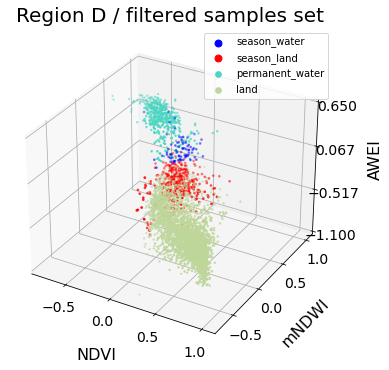

In [12]:
# %matplotlib notebook
%matplotlib inline
x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'

land_x =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 


land_x1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 
# 创建一个三维的绘图工程
# plt.figure(figsize=(10, 8))
plt.figure(figsize=(8, 6))

ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'season_water')
ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'season_land')  
ax.scatter(water_x1, water_y1, water_z1, s=2, c='#4ad6c3', label = 'permanent_water')
ax.scatter(land_x1, land_y1, land_z1, s=2,c='#bfd69b', label = 'land')

# ax.view_init(32,-51)
# 坐标轴
ax.set_xlim3d(-0.85,1.1)
ax.set_ylim3d(-0.8,1.1)
ax.set_zlim3d(-1.1,0.65)
plt.tick_params(labelsize=14)
ax.set_xlabel(x,labelpad = 16,fontsize = 16)
ax.set_ylabel(y,labelpad = 16,fontsize = 16)
ax.set_zlabel(z,labelpad = 16,rotation=90,fontsize = 16)
plt.xticks([-0.5,0,0.5,1.0])
plt.yticks([-0.5,0,0.5,1.0])
ax.zaxis.set_major_locator(LinearLocator(4))
plt.title(name + ' / filtered samples set',fontsize = 20) 
plt.legend(loc='upper right',markerscale=4,prop={'size':10})
plt.show()

## 异常值

In [16]:
# samples = k_mean_outlier(total_Samples)
# print("异常点： ",samples.size().getInfo())
# # 永久性水体、非水体的样本
# permanent_w = samples.filter(ee.Filter.eq('point_type','permanent_water'))
# no_w = samples.filter(ee.Filter.eq('point_type','no_water')).filter(ee.Filter.lt('AWEI',1))
# filtered_samples1 = ee.FeatureCollection([permanent_w,no_w]).flatten()
# print(filtered_samples1.size().getInfo())
# # 季节性水体的样本
# filtered_samples = samples.filter(ee.Filter.eq('point_type','season')).filter(ee.Filter.gt('AWEI',-1))
# print(filtered_samples.size().getInfo())

异常点：  21
8
5


In [14]:
samples = k_mean_outlier(total_Samples)
print("异常点： ",samples.size().getInfo())
# 永久性水体、非水体的样本
permanent_w = samples.filter(ee.Filter.eq('point_type','permanent_water'))
no_w = samples.filter(ee.Filter.eq('point_type','no_water'))
filtered_samples1 = ee.FeatureCollection([permanent_w,no_w]).flatten()
print(filtered_samples1.size().getInfo())
# 季节性水体的样本
filtered_samples = samples.filter(ee.Filter.eq('point_type','season'))
print(filtered_samples.size().getInfo())

异常点：  21
16
5


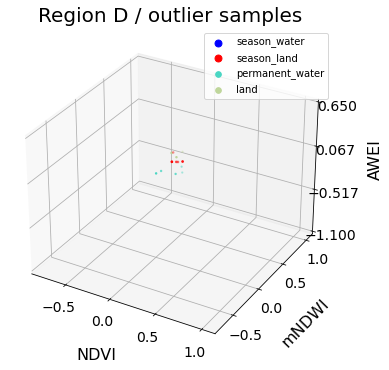

In [17]:
# %matplotlib notebook
%matplotlib inline
x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'

land_x =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 


land_x1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 
# 创建一个三维的绘图工程
# plt.figure(figsize=(10, 8))
plt.figure(figsize=(8, 6))

ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'season_water')
ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'season_land')  
ax.scatter(water_x1, water_y1, water_z1, s=2, c='#4ad6c3', label = 'permanent_water')
ax.scatter(land_x1, land_y1, land_z1, s=2,c='#bfd69b', label = 'land')

# ax.view_init(32,-51)
# 坐标轴
ax.set_xlim3d(-0.85,1.1)
ax.set_ylim3d(-0.8,1.1)
ax.set_zlim3d(-1.1,0.65)
plt.tick_params(labelsize=14)
ax.set_xlabel(x,labelpad = 16,fontsize = 16)
ax.set_ylabel(y,labelpad = 16,fontsize = 16)
ax.set_zlabel(z,labelpad = 16,rotation=90,fontsize = 16)
plt.xticks([-0.5,0,0.5,1.0])
plt.yticks([-0.5,0,0.5,1.0])
ax.zaxis.set_major_locator(LinearLocator(4))
plt.title(name + ' / outlier samples',fontsize = 20) 
plt.legend(loc='upper right',markerscale=4,prop={'size':10})
plt.show()

# 备用

In [ ]:
pw_nw = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_noseason' + str(year))
permanent_water = pw_nw.filter(ee.Filter.eq('waterclass',1)).randomColumn('random',1,'uniform').sort('random').limit(500)
no_water = pw_nw.filter(ee.Filter.eq('waterclass',0)).randomColumn('random',1,'uniform').sort('random').limit(3000)
print('抽样的永久性水体： ',permanent_water.size().getInfo())
print('抽样的非水体： ',no_water.size().getInfo())
## 季节性样本，抽样
# sw = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_season' + str(year)+'_v2').randomColumn('random',1,'uniform').sort('random').limit(500)
sw = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_season' + str(year)).randomColumn('random',1,'uniform').sort('random').limit(500)
print('抽样的季节性水体： ',sw.size().getInfo())
## 季节性样本，分类
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
cluster_samples = ee.FeatureCollection([permanent_water,no_water]).flatten()
clusterer = ee.Clusterer.wekaKMeans(2).train(cluster_samples,bands)
q = ee.FeatureCollection(sw.cluster(clusterer))
q1 = q.filter(ee.Filter.eq('cluster',1))
q0 = q.filter(ee.Filter.eq('cluster',0))
b1 = ee.FeatureCollection(q1).filter(ee.Filter.lt('AWEI',0)).size()
b2 = ee.FeatureCollection(q1).filter(ee.Filter.gt('AWEI',0)).size()
c1 = ee.FeatureCollection(q0).filter(ee.Filter.lt('AWEI',0)).size()
c2 = ee.FeatureCollection(q0).filter(ee.Filter.gt('AWEI',0)).size()
qq1 = ee.Algorithms.If(ee.Number(b1).lt(ee.Number(b2)),q1.map(lambda i:i.set({'waterclass':1})),q1.map(lambda i:i.set({'waterclass':0})))
qq0 = ee.Algorithms.If(ee.Number(c1).lt(ee.Number(c2)),q0.map(lambda i:i.set({'waterclass':1})),q0.map(lambda i:i.set({'waterclass':0})))
seasonWater = ee.FeatureCollection([qq1,qq0]).flatten()
## 合并
total_Samples = ee.FeatureCollection([permanent_water,no_water,seasonWater]).flatten()
print("筛选前，剩余的样本数： ",total_Samples.size().getInfo())

## 异常值去除
filtered_samples = k_mean(total_Samples)
print("筛选后，剩余的样本数： ",filtered_samples.size().getInfo())
filtered_samples1 = k_mean_outlier(total_Samples)
print("异常点： ",filtered_samples1.size().getInfo())
print("比例： ",filtered_samples1.size().getInfo() / total_Samples.size().getInfo())

# # 永久性水体、非水体的样本
# samples = k_mean(total_Samples)
# permanent_water = samples.filter(ee.Filter.eq('point_type','permanent_water'))
# no_water = samples.filter(ee.Filter.eq('point_type','no_water'))
# filtered_samples1 = ee.FeatureCollection([permanent_water,no_water]).flatten()
# print(filtered_samples1.size().getInfo())
# # 季节性水体的样本
# filtered_samples = samples.filter(ee.Filter.eq('point_type','season'))
# print(filtered_samples.size().getInfo())

In [ ]:
# filtered_samples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + str(year))
# print('筛选前，剩余的样本数： ',filtered_samples.size().getInfo())

In [ ]:
# %matplotlib notebook
%matplotlib inline
x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'

land_x =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(filtered_samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 


land_x1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z1 =np.array(filtered_samples1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 
# 创建一个三维的绘图工程
# plt.figure(figsize=(10, 8))
plt.figure(figsize=(8, 6))

ax = plt.subplot(111, projection='3d')  
# 绘制数据点
# ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'water')
# ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'land')  
# ax.scatter(water_x1, water_y1, water_z1, s=4, c='blue', label = 'remian_water')
# ax.scatter(land_x1, land_y1, land_z1, s=4,c='red', label = 'remain_land')

# ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'water')
# ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'land') 
# ax.scatter(water_x1, water_y1, water_z1, s=3, c='blue')
# ax.scatter(land_x1, land_y1, land_z1, s=3,c='red')

# ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'remain_water')
# ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'remain_land')
# ax.scatter(water_x1, water_y1, water_z1, s=3, c='blue', label = 'outlier_water')
# ax.scatter(land_x1, land_y1, land_z1, s=3,c='red', label = 'outlier_land')

# ax.scatter(water_x, water_y, water_z, s=2, c='blue', label = 'remain_water')
# ax.scatter(land_x, land_y, land_z, s=2,c='red', label = 'remain_land')  
# ax.scatter(water_x1, water_y1, water_z1, s=4, c='#15ff06', label = 'outlier_water')
# ax.scatter(land_x1, land_y1, land_z1, s=4,c='#08ffff', label = 'outlier_land')



# ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'season_water')
# ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'season_land')  
# ax.scatter(water_x1, water_y1, water_z1, s=2, c='#4ad6c3', label = 'permanent_water')
# ax.scatter(land_x1, land_y1, land_z1, s=2,c='#bfd69b', label = 'land')

# ax.view_init(32,-51)
# 坐标轴
ax.set_xlim3d(-0.85,1.1)
ax.set_ylim3d(-0.8,1.1)
ax.set_zlim3d(-15000,5300)
plt.tick_params(labelsize=14)
ax.set_xlabel(x,labelpad = 16,fontsize = 16)
ax.set_ylabel(y,labelpad = 16,fontsize = 16)
ax.set_zlabel(z,labelpad = 16,rotation=90,fontsize = 16)
plt.xticks([-0.5,0,0.5,1.0])
plt.yticks([-0.5,0,0.5,1.0])
plt.title('Title: NDVI/MNDWI/AWEI',fontsize = 20) 
plt.legend(loc='upper right',markerscale=4,prop={'size':10})
plt.show()

In [ ]:
x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'
# 全部样本
land_x1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

land_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

# 创建一个三维的绘图工程
# plt.figure(figsize=(10, 8))
plt.figure(figsize=(8, 6))

ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'season_water')
ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'season_land')  
ax.scatter(water_x1, water_y1, water_z1, s=2, c='#4ad6c3', label = 'permanent_water')
ax.scatter(land_x1, land_y1, land_z1, s=2,c='#bfd69b', label = 'land')

# ax.view_init(30,-50)
# 坐标轴
ax.set_xlim3d(-0.85,1.1)
ax.set_ylim3d(-0.8,1.1)
ax.set_zlim3d(-15000,5300)
plt.tick_params(labelsize=14)
ax.set_xlabel(x,labelpad = 16,fontsize = 16)
ax.set_ylabel(y,labelpad = 16,fontsize = 16)
ax.set_zlabel(z,labelpad = 16,rotation=90,fontsize = 16)
plt.xticks([-0.5,0,0.5,1.0])
plt.yticks([-0.5,0,0.5,1.0])
plt.title('Title: NDVI/MNDWI/AWEI',fontsize = 20) 
plt.legend(loc='upper right',markerscale=4,prop={'size':14})
plt.show()
